In [1]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
LSKmix= np.array(pd.read_csv ('../data/processed_data/LSKmix.csv'))
y = np.array(LSKmix[:,-1],dtype=int)
LSKmix= LSKmix[:,0:-1]


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSKmix,y)

In [5]:
print(LSKmix.shape, len(pred))
acc = model.score_
print(acc)

(1023, 7230) 1023
0.11730769230769231


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (122.0, 918.0, 0.1328976034858388, 0.29539951573849876, 0.9941638322896469, 0.11730769230769231, 0.9981425689994128, 0.8826923076923077, 0.7046004842615012)


# Mutual information maximizer (MIM)

test 0.27754506553354485 0.02986839534041332
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (148.0, 807.0, 0.18339529120198264, 0.26714801444043323, 0.9958914361645258, 0.1549738219895288, 0.9979287616443387, 0.8450261780104712, 0.7328519855595668)


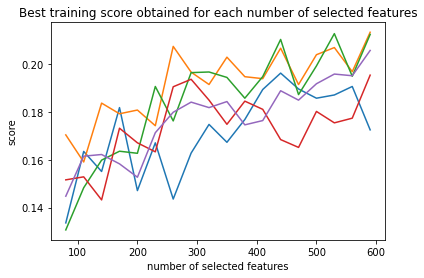

In [7]:
#Define parameters for MIM method
N = np.arange(80,600,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSKmix, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSKmix[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

test 0.2865741838827226 0.03986084244019426
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (168.0, 886.0, 0.18961625282167044, 0.3708609271523179, 0.993944902715226, 0.15939278937381404, 0.9980442211882901, 0.8406072106261859, 0.6291390728476821)


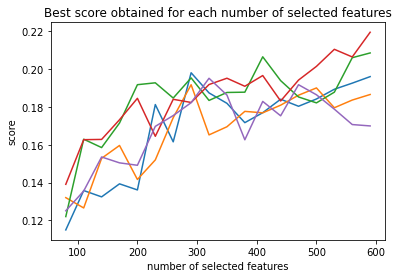

In [8]:
#Define parameters for ANOVA method
N = np.arange(80,600,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSKmix, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSKmix[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

# Hybrid methods

# Mutual information and stimulated annealing

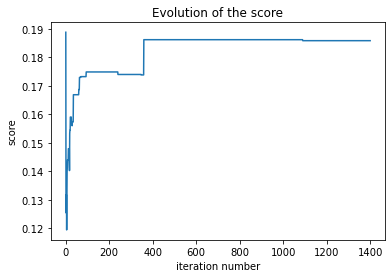

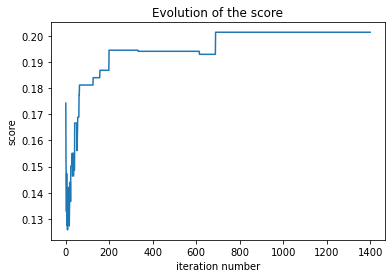

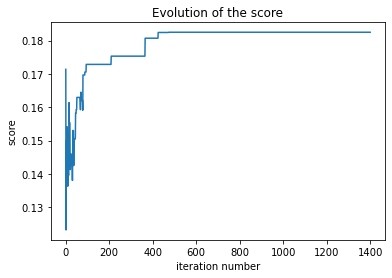

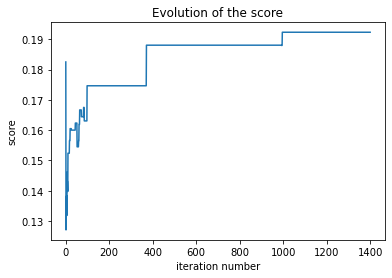

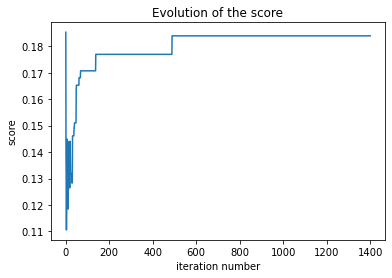

test 0.27145878679689817 0.020247407018789423
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (149.0, 887.0, 0.16798196166854565, 0.30785123966942146, 0.9947164641410531, 0.1438223938223938, 0.9979979441575827, 0.8561776061776062, 0.6921487603305785)


In [9]:
#Define parameters for MI + stimulated annealing method
N = np.array([400])
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_iter': 1400, 'n_neighbors': 3, 'p_mutate': 0.1, 'c': 1, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSKmix, FamiliesClusters, compute_precision,True, 5,  MI_stimulated_annealing, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSKmix[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

# Mutual information and genetic feature selection

(713,) (596,) (117,)
(713, 7289) (596, 7289) (117, 7289)
(713,) (697,) (16,)
(713, 7289) (697, 7289) (16, 7289)
(713,) (713,) (0,)
(713, 7289) (713, 7289) (0, 7289)


ValueError: The number of observations cannot be determined on an empty distance matrix.

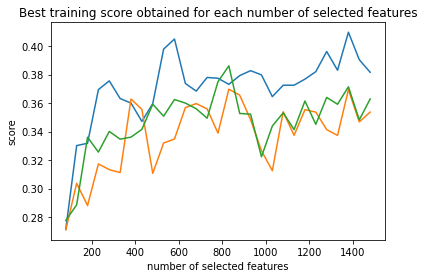

In [3]:
ind_dataset = np.squeeze(np.array(pd.read_csv('../data/processed_data/size_librariesLSKmix.csv')))
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LSKmixfusedlibrary.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]

#Define parameters for MIM method
N = np.arange(80,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset_MIM, score_training, score_testing = optimization_on_allsets(y,LK, ind_dataset, FamiliesClusters, compute_precision,True, MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# ANOVA iterating through the different libraries

In [ ]:
#Define parameters for ANOVA method
N = np.arange(80,2000,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset_ANOVA, score_training, score_testing = optimization_on_allsets(y,LK, ind_dataset, FamiliesClusters, compute_precision,True, ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)